In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Train data/annotated_3cat_3_random.csv')

In [ ]:
train.shape

(25103, 2)

In [ ]:
train = train.drop_duplicates()

In [ ]:
train.rename(columns = {'Sentiment':'sentiment'}, inplace = True)
#train.rename(columns = {'Tweet':'text'}, inplace = True)
train

,text,sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive
...,...,...
25098,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
25099,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
25100,In April 2016 computer technicians at the Demo...,Neutral
25101,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
#dataset lenght
len(train)

25103

In [ ]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [ ]:
#How distributed is the dataset?
train.groupby('sentiment').nunique()

,text
sentiment,
Negative,7449
Neutral,9914
Positive,7738


# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
#Let's fill the only null value.
train["text"].fillna("No content", inplace = True)

In [ ]:
train = train.dropna()

In [ ]:
#train = train.drop_duplicates()

In [ ]:
train.shape

(25103, 2)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = train['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Bitcoin is unfolding like the dot com crash just 15 times faster BTC USD BITCOIN',
 'XEM Price is 0 00003330 0 00000044 BTC 0 286412 0 00641 USD Market rank is 13 nem bitcoin blockchain',
 'RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTLOOK Cautiously bearish Bear doji reversal favors sell off But ve',
 'Dutch Court Finds Bitcoin A Legitimate Transferable Value XBT BTC Bitcoin',
 'BTC STEEM AskRate 0 00024274 Bittrex STEEM STEEM STEEM altcoin altcoins bitcoin FOLLOW for PROFIT']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['bitcoin', 'is', 'unfolding', 'like', 'the', 'dot', 'com', 'crash', 'just', 'times', 'faster', 'btc', 'usd', 'bitcoin'], ['xem', 'price', 'is', 'btc', 'usd', 'market', 'rank', 'is', 'nem', 'bitcoin', 'blockchain'], ['rt', 'bitcoin', 'daily', 'snapshot', 'hr', 'change', 'outlook', 'cautiously', 'bearish', 'bear', 'doji', 'reversal', 'favors', 'sell', 'off', 'but', 've'], ['dutch', 'court', 'finds', 'bitcoin', 'legitimate', 'transferable', 'value', 'xbt', 'btc', 'bitcoin'], ['btc', 'steem', 'askrate', 'bittrex', 'steem', 'steem', 'steem', 'altcoin', 'altcoins', 'bitcoin', 'follow', 'for', 'profit'], ['this', 'is', 'our', 'free', 'bitcoin', 'miner', 'pays', 'at', 'sathoshi'], ['bitcoin', 'basics', 'cryptocurrency', 'blockchain', 'and', 'the', 'new', 'digital', 'economy', 'digital', 'currency', 'cryptocurre', 'blockchain'], ['block', 'size', 'kb', 'fee', 'kb', 'price', 'bitcoin', 'btc', 'btc', 'xbt', 'xbt'], ['the', 'latest', 'the', 'aquilante', 'daily', 'thanks', 'to', 'cybersecurity', 

In [ ]:
len(data_words)

25103

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['bitcoin is unfolding like the dot com crash just times faster btc usd bitcoin', 'xem price is btc usd market rank is nem bitcoin blockchain', 'rt bitcoin daily snapshot hr change outlook cautiously bearish bear doji reversal favors sell off but ve', 'dutch court finds bitcoin legitimate transferable value xbt btc bitcoin', 'btc steem askrate bittrex steem steem steem altcoin altcoins bitcoin follow for profit']


In [ ]:
data = np.array(data)

# Label encoding

In [ ]:
labels = np.array(train['sentiment'])
y = []


for i in range(len(labels)):
    if labels[i] == "Neutral":
        y.append(0)
    if labels[i] == "Negative":
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)


"""

for i in range(len(labels)):
    if labels[i] == 0.0:
        y.append(0)
    if labels[i] == -1.0:
        y.append(1)
    if labels[i] == 1.0:
        y.append(2)

"""
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y


In [ ]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
len(labels)

25103

##Rough (splitting to compare with other models)

In [ ]:
train.head()

,text,sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive


In [ ]:
labels2 = np.array(train['sentiment'])
sent_ = []

for i in range(len(labels2)):
    if labels2[i] == "Neutral":
        sent_.append(0)
    if labels2[i] == "Negative":
        sent_.append(1)
    if labels2[i] == "Positive":
        sent_.append(2)

In [ ]:
len(data)

25103

In [ ]:
#Splitting the data
X_train2, X_tal2, y_train2, y_tal2 = train_test_split(data,sent_, test_size = 0.4, random_state=42)
print (len(X_train2),len(y_train2))

15061 15061


In [ ]:
#Splitting the data (validation and testing)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_tal2,y_tal2, test_size = 0.5, random_state=42)
print (len(X_val2), len(X_test2), len(y_val2), len(y_test2))

5021 5021 5021 5021


In [ ]:
comp1 = pd.DataFrame(X_test2, columns = ['text'])
comp2 = pd.DataFrame(y_test2, columns = ['sentiment'])


In [ ]:
t1 = pd.DataFrame(X_train2, columns = ['text'])
t2 = pd.DataFrame(y_train2, columns = ['sentiment'])

In [ ]:
def transform_sentiment_2(senti):
    if senti == 0:
        return "Neutral"
    if senti == 1:
        return "Negative"
    if senti == 2:
        return "Positive"

comp2['sentiment'] = comp2['sentiment'].apply(lambda senti: transform_sentiment_2(senti)).astype(str)


In [ ]:
comp2

,sentiment
0,Neutral
1,Positive
2,Neutral
3,Neutral
4,Neutral
...,...
5016,Negative
5017,Positive
5018,Neutral
5019,Neutral


In [ ]:
comp1

,text
0,puerto rico creates working group to review bl...
1,in the book we will be talking about deploying...
2,an online service for working with mirabox con...
3,our team at the satoshi vision conference in t...
4,the us postal service is looking at backing up...
...,...
5016,europefx latest in celebrity bitcoin trading s...
5017,how to get free bitcoin money
5018,ramencoin airdrop ramencoin ramen airdrop boun...
5019,gbpcad bull flag gbpcad tradingview forex fore...


In [ ]:
comp = pd.concat([comp1,comp2],axis=1)

In [ ]:
comp

,text,sentiment
0,puerto rico creates working group to review bl...,Neutral
1,in the book we will be talking about deploying...,Positive
2,an online service for working with mirabox con...,Neutral
3,our team at the satoshi vision conference in t...,Neutral
4,the us postal service is looking at backing up...,Neutral
...,...,...
5016,europefx latest in celebrity bitcoin trading s...,Negative
5017,how to get free bitcoin money,Positive
5018,ramencoin airdrop ramencoin ramen airdrop boun...,Neutral
5019,gbpcad bull flag gbpcad tradingview forex fore...,Neutral


# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    6   40    1]
 [   0    0    0 ...  592    1   11]
 [   0    0    0 ...  238   70  346]
 ...
 [   0    0    0 ...  653   80    1]
 [   0    0    0 ... 1059   28  426]
 [   0    0    0 ...  405   73  118]]


In [ ]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
#Splitting the data
X_train, X_tal, y_train, y_tal = train_test_split(tweets,labels, test_size = 0.4, random_state=42)
print (len(X_train),len(y_train))

15061 15061


In [ ]:
#Splitting the data (validation and testing)
X_val, X_test, y_val, y_test = train_test_split(X_tal,y_tal, test_size = 0.5, random_state=42)
print (len(X_val), len(X_test), len(y_val), len(y_test))

5021 5021 5021 5021


In [ ]:
X_train

array([[   0,    0,    0, ...,   27,  163,    1],
       [   0,    0,    0, ...,  198,  447,   35],
       [   0,    0,    0, ...,  812, 2611,   60],
       ...,
       [   0,    0,    0, ...,  127,   81,  345],
       [   0,    0,    0, ...,    8,  205,  458],
       [   0,    0,    0, ..., 2345,    1, 1132]], dtype=int32)

##RNN model

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 20))
model0.add(layers.SimpleRNN(15,dropout=0.5))
model0.add(layers.Dense(3,activation='softmax'))

In [ ]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 15)                540       
                                                                 
 dense (Dense)               (None, 3)                 48        
                                                                 
Total params: 100,588
Trainable params: 100,588
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model0.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_single_rnn.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history0 = model0.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint0])

Epoch 1/20
470/471 [============================>.] - ETA: 0s - loss: 0.9465 - accuracy: 0.5382
Epoch 1: val_loss improved from inf to 0.81479, saving model to /content/drive/MyDrive/Models/3rd_try_single_rnn.hdf5
471/471 [==============================] - 48s 98ms/step - loss: 0.9463 - accuracy: 0.5384 - val_loss: 0.8148 - val_accuracy: 0.6395
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.6919
Epoch 2: val_loss improved from 0.81479 to 0.63751, saving model to /content/drive/MyDrive/Models/3rd_try_single_rnn.hdf5
471/471 [==============================] - 27s 57ms/step - loss: 0.7311 - accuracy: 0.6919 - val_loss: 0.6375 - val_accuracy: 0.7451
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7692
Epoch 3: val_loss improved from 0.63751 to 0.57188, saving model to /content/drive/MyDrive/Models/3rd_try_single_rnn.hdf5
471/471 [==============================] - 27s 58ms/step - loss: 0.5791 - accuracy: 

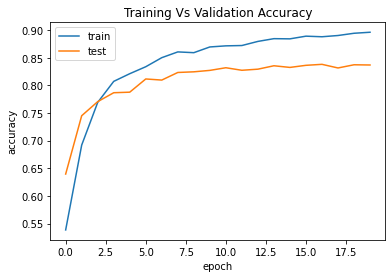

In [ ]:
# plot accuracy (train vs val)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

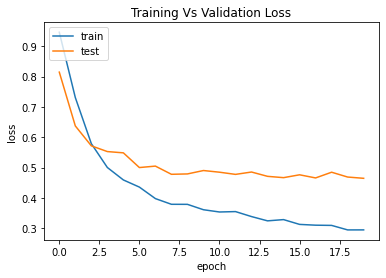

In [ ]:
# plot loss (train vs val)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Single LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm_1 (LSTM)               (None, 15)                2160      
                                                                 
 dense_2 (Dense)             (None, 3)                 48        
                                                                 
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model1.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_single_lstm.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint1])

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.5252
Epoch 1: val_loss improved from inf to 0.82691, saving model to /content/drive/MyDrive/Models/3rd_try_single_lstm.hdf5
471/471 [==============================] - 44s 89ms/step - loss: 0.9625 - accuracy: 0.5252 - val_loss: 0.8269 - val_accuracy: 0.6495
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.6949
Epoch 2: val_loss improved from 0.82691 to 0.62478, saving model to /content/drive/MyDrive/Models/3rd_try_single_lstm.hdf5
471/471 [==============================] - 45s 95ms/step - loss: 0.7180 - accuracy: 0.6949 - val_loss: 0.6248 - val_accuracy: 0.7403
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.7803
Epoch 3: val_loss improved from 0.62478 to 0.55062, saving model to /content/drive/MyDrive/Models/3rd_try_single_lstm.hdf5
471/471 [==============================] - 44s 94ms/step - loss: 0.5545 - accurac

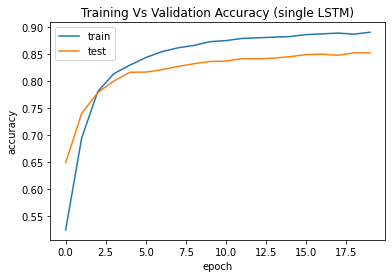

In [ ]:
# plot accuracy (train vs val)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (single LSTM)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

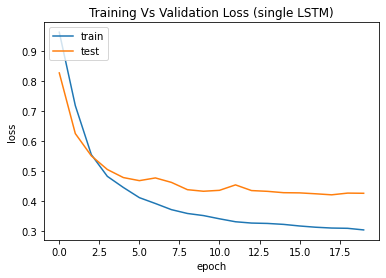

In [ ]:
# plot loss (train vs val)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation Loss (single LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#k_fold (5) cross validation on single layer lstm

In [ ]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1

#skf = StratifiedKFold(n_splits=10, shuffle=True)

for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model6 = Sequential()
  model6.add(layers.Embedding(max_words, 20))
  model6.add(layers.LSTM(15,dropout=0.5))
  model6.add(layers.Dense(3,activation='softmax'))

  # Compile the model
  model6.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  #model1.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  #Implementing model checkpoins to save the best metric and do not lose it on training.
  checkpoint6 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_kfold_single_lstm.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
  history6 = model6.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint6])

  # Generate generalization metrics
  score = model6.evaluate(inputs[test], targets[test], verbose=0)
  print(f'val loss: {score[0]} / val accuracy: {score[1]}')

  fold_no = fold_no + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 1.0859 - accuracy: 0.3911
Epoch 1: val_loss improved from inf to 1.06931, saving model to /content/drive/MyDrive/Models/3rd_try_kfold_single_lstm.hdf5
471/471 [==============================] - 65s 132ms/step - loss: 1.0859 - accuracy: 0.3911 - val_loss: 1.0693 - val_accuracy: 0.3995
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 1.0546 - accuracy: 0.4360
Epoch 2: val_loss improved from 1.06931 to 1.03478, saving model to /content/drive/MyDrive/Models/3rd_try_kfold_single_lstm.hdf5
471/471 [==============================] - 49s 103ms/step - loss: 1.0546 - accuracy: 0.4360 - val_loss: 1.0348 - val_accuracy: 0.4800
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 1.0211 - accuracy: 0.4885
Epoch 3: val_loss improved from 1.03478 to 0.99806, saving model to /content/drive/MyDrive/Mo

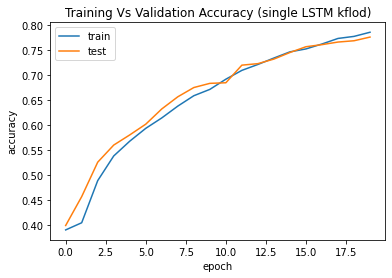

In [ ]:
# plot accuracy (train vs val)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (single LSTM kflod)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

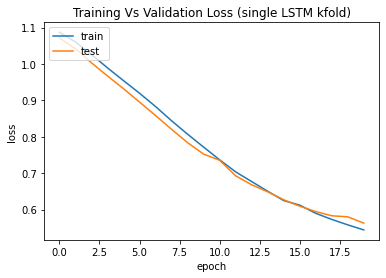

In [ ]:
# plot loss (train vs val)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Training Vs Validation Loss (single LSTM kfold)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#kfold (30 epoch)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1

#skf = StratifiedKFold(n_splits=10, shuffle=True)

for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model7 = Sequential()
  model7.add(layers.Embedding(max_words, 20))
  model7.add(layers.LSTM(15,dropout=0.5))
  model7.add(layers.Dense(3,activation='softmax'))

  # Compile the model
  model7.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  #model1.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  #Implementing model checkpoins to save the best metric and do not lose it on training.
  checkpoint7 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_kfold_single_lstm2(30_epoch).hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
  history7 = model7.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),callbacks=[checkpoint7])

  # Generate generalization metrics
  score = model7.evaluate(inputs[test], targets[test], verbose=0)
  print(f'val loss: {score[0]} / val accuracy: {score[1]}')

  fold_no = fold_no + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
471/471 [==============================] - ETA: 0s - loss: 1.0883 - accuracy: 0.3907
Epoch 1: val_loss improved from inf to 1.07438, saving model to /content/drive/MyDrive/Models/3rd_try_kfold_single_lstm2(30_epoch).hdf5
471/471 [==============================] - 66s 135ms/step - loss: 1.0883 - accuracy: 0.3907 - val_loss: 1.0744 - val_accuracy: 0.3993
Epoch 2/30
471/471 [==============================] - ETA: 0s - loss: 1.0597 - accuracy: 0.4101
Epoch 2: val_loss improved from 1.07438 to 1.03934, saving model to /content/drive/MyDrive/Models/3rd_try_kfold_single_lstm2(30_epoch).hdf5
471/471 [==============================] - 58s 123ms/step - loss: 1.0597 - accuracy: 0.4101 - val_loss: 1.0393 - val_accuracy: 0.4282
Epoch 3/30
471/471 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.4887
Epoch 3: val_loss improved from 1.03934 to 0.99814, saving model to /co

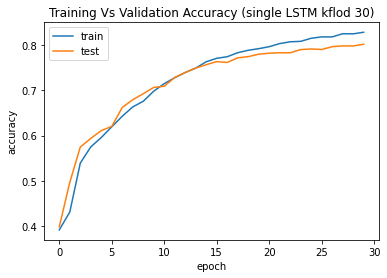

In [ ]:
# plot accuracy (train vs val)
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (single LSTM kflod 30)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

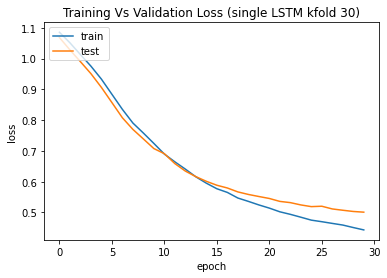

In [ ]:
# plot loss (train vs val)
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Training Vs Validation Loss (single LSTM kfold 30)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Double layer LSTM (same parameters)

In [ ]:
model3_1 = Sequential()
model3_1.add(layers.Embedding(max_words, 20))
model3_1.add(layers.LSTM(15,dropout=0.5,return_sequences=True))
model3_1.add(layers.LSTM(5,dropout=0.5))
model3_1.add(layers.Dense(3,activation='softmax'))

In [ ]:
model3_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm_4 (LSTM)               (None, None, 15)          2160      
                                                                 
 lstm_5 (LSTM)               (None, 5)                 420       
                                                                 
 dense_4 (Dense)             (None, 3)                 18        
                                                                 
Total params: 102,598
Trainable params: 102,598
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model3_1.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint3_1 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_double_lstm(same_param).hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history3_1 = model3_1.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint3_1])

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.5853
Epoch 1: val_loss improved from inf to 0.73027, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm(same_param).hdf5
471/471 [==============================] - 91s 183ms/step - loss: 0.9148 - accuracy: 0.5853 - val_loss: 0.7303 - val_accuracy: 0.7116
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.7437
Epoch 2: val_loss improved from 0.73027 to 0.58648, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm(same_param).hdf5
471/471 [==============================] - 81s 173ms/step - loss: 0.6466 - accuracy: 0.7437 - val_loss: 0.5865 - val_accuracy: 0.7720
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.7885
Epoch 3: val_loss improved from 0.58648 to 0.51991, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm(same_param).hdf5
471/471 [==============================] - 

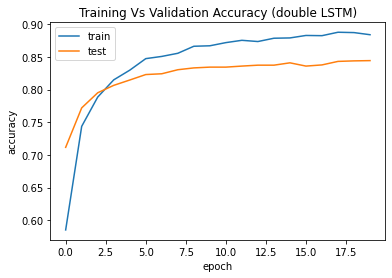

In [ ]:
# plot accuracy (train vs val)
plt.plot(history3_1.history['accuracy'])
plt.plot(history3_1.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (double LSTM)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

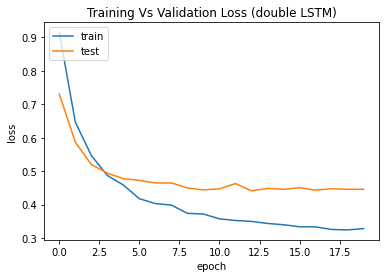

In [ ]:
# plot loss (train vs val)
plt.plot(history3_1.history['loss'])
plt.plot(history3_1.history['val_loss'])
plt.title('Training Vs Validation Loss (double LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Double layer lstm model(20 epoch)

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=max_words, output_dim=15, input_length=max_len))
model3.add(layers.LSTM(20,dropout=0.5,return_sequences=True))
model3.add(layers.LSTM(10,dropout=0.5))
model3.add(layers.Dense(3,activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 15)           75000     
                                                                 
 lstm_8 (LSTM)               (None, 200, 20)           2880      
                                                                 
 lstm_9 (LSTM)               (None, 10)                1240      
                                                                 
 dense_6 (Dense)             (None, 3)                 33        
                                                                 
Total params: 79,153
Trainable params: 79,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model3.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint3 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_double_lstm.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history3 = model3.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint3])

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.9306 - accuracy: 0.5643
Epoch 1: val_loss improved from inf to 0.73071, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm.hdf5
471/471 [==============================] - 96s 190ms/step - loss: 0.9306 - accuracy: 0.5643 - val_loss: 0.7307 - val_accuracy: 0.6999
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7272
Epoch 2: val_loss improved from 0.73071 to 0.57938, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm.hdf5
471/471 [==============================] - 83s 176ms/step - loss: 0.6682 - accuracy: 0.7272 - val_loss: 0.5794 - val_accuracy: 0.7698
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.7818
Epoch 3: val_loss improved from 0.57938 to 0.52598, saving model to /content/drive/MyDrive/Models/3rd_try_double_lstm.hdf5
471/471 [==============================] - 83s 176ms/step - loss: 0.5567 - accu

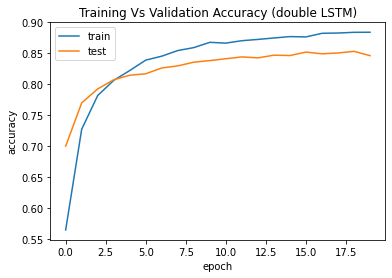

In [ ]:
# plot accuracy (train vs val)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (double LSTM)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

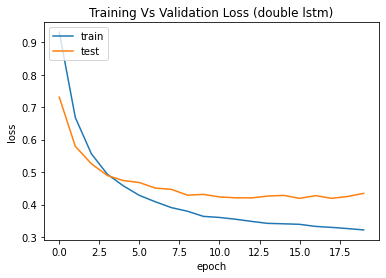

In [ ]:
# plot loss (train vs val)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Training Vs Validation Loss (double lstm)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Single BiLSTM Layer Model

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 20))
model2.add(layers.Bidirectional(layers.LSTM(15,dropout=0.5)))
model2.add(layers.Dense(3,activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 20)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 30)               4320      
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 3)                 93        
                                                                 
Total params: 104,413
Trainable params: 104,413
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_single_bilstm.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history2 = model2.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint2])

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.5369
Epoch 1: val_loss improved from inf to 0.81043, saving model to /content/drive/MyDrive/Models/3rd_try_single_bilstm.hdf5
471/471 [==============================] - 80s 160ms/step - loss: 0.9584 - accuracy: 0.5369 - val_loss: 0.8104 - val_accuracy: 0.6640
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.7105
Epoch 2: val_loss improved from 0.81043 to 0.62700, saving model to /content/drive/MyDrive/Models/3rd_try_single_bilstm.hdf5
471/471 [==============================] - 67s 142ms/step - loss: 0.6951 - accuracy: 0.7105 - val_loss: 0.6270 - val_accuracy: 0.7524
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.7878
Epoch 3: val_loss improved from 0.62700 to 0.53705, saving model to /content/drive/MyDrive/Models/3rd_try_single_bilstm.hdf5
471/471 [==============================] - 64s 136ms/step - loss: 0.5441 

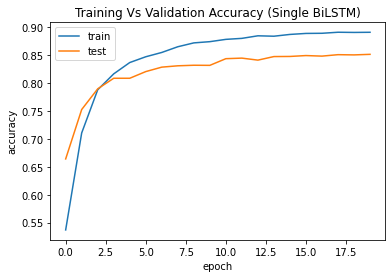

In [ ]:
# plot accuracy (train vs val)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy (Single BiLSTM)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

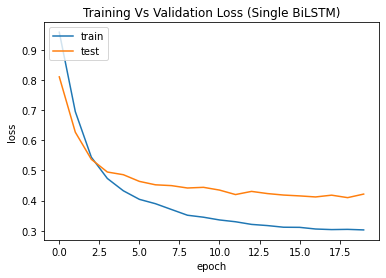

In [ ]:
# plot loss (train vs val)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training Vs Validation Loss (Single BiLSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##1D Convolution (CNN-LSTM)

In [ ]:
#20 epoch model
'''model4 = Sequential()
model4.add(layers.Embedding(max_words, 15, input_length=max_len))
model4.add(layers.Conv1D(15, 5, activation='relu'))
model4.add(layers.MaxPooling1D(5))
model4.add(layers.LSTM(8, dropout=0.5))
model4.add(layers.Dense(3,activation='softmax'))'''

from keras import regularizers
model4 = Sequential()
model4.add(layers.Embedding(max_words, 15, input_length=max_len))
model4.add(layers.Conv1D(20, 5, activation='relu'))
model4.add(layers.MaxPooling1D(5))
model4.add(layers.LSTM(10, dropout=0.5))
model4.add(layers.Dense(3,activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 15)           75000     
                                                                 
 conv1d (Conv1D)             (None, 196, 20)           1520      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 20)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 10)                1240      
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 77,793
Trainable params: 77,793
Non-trainable params: 0
____________________________________________________

In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model4.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint4 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_single_cnn_lstm(10epoch).hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history4 = model4.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val),callbacks=[checkpoint4])

Epoch 1/10
471/471 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.5549
Epoch 1: val_loss improved from inf to 0.71447, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_lstm(10epoch).hdf5
471/471 [==============================] - 18s 32ms/step - loss: 0.9467 - accuracy: 0.5549 - val_loss: 0.7145 - val_accuracy: 0.7309
Epoch 2/10
470/471 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.7531
Epoch 2: val_loss improved from 0.71447 to 0.53275, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_lstm(10epoch).hdf5
471/471 [==============================] - 14s 30ms/step - loss: 0.6239 - accuracy: 0.7533 - val_loss: 0.5327 - val_accuracy: 0.7947
Epoch 3/10
471/471 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.8124
Epoch 3: val_loss improved from 0.53275 to 0.48615, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_lstm(10epoch).hdf5
471/471 [==============================] -

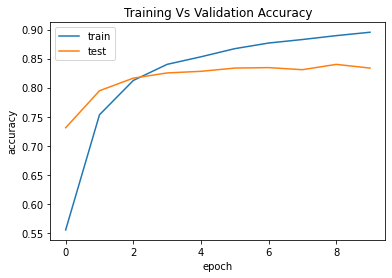

In [ ]:
# plot accuracy (train vs val)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

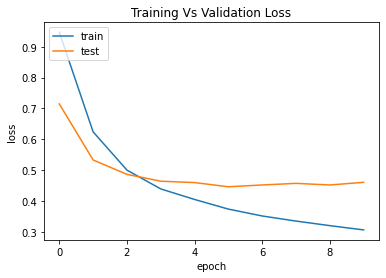

In [ ]:
# plot loss (train vs val)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##CNN-BiLSTM

In [ ]:
#Previous model5.add(layers.Bidirectional(layers.LSTM(10, dropout=0.5)))

from keras import regularizers
model5 = Sequential()
model5.add(layers.Embedding(max_words, 15, input_length=max_len))
model5.add(layers.Conv1D(20, 5, activation='relu'))
model5.add(layers.MaxPooling1D(5))
model5.add(layers.Bidirectional(layers.LSTM(8, dropout=0.5)))
model5.add(layers.Dense(3,activation='softmax'))

In [ ]:
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 15)           75000     
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 20)           1520      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 39, 20)           0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 16)               1856      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 78,427
Trainable params: 78,427
Non-trai

In [ ]:
RMSprop(learning_rate=0.0001, name='rmsprop')
model5.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint5 = ModelCheckpoint("/content/drive/MyDrive/Models/3rd_try_single_cnn_bilstm2.hdf5", 
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='auto',
                              save_weights_only=False)
history5 = model5.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val),callbacks=[checkpoint5])

Epoch 1/10
470/471 [============================>.] - ETA: 0s - loss: 0.9553 - accuracy: 0.5535
Epoch 1: val_loss improved from inf to 0.72834, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_bilstm2.hdf5
471/471 [==============================] - 23s 39ms/step - loss: 0.9553 - accuracy: 0.5537 - val_loss: 0.7283 - val_accuracy: 0.7325
Epoch 2/10
470/471 [============================>.] - ETA: 0s - loss: 0.6376 - accuracy: 0.7533
Epoch 2: val_loss improved from 0.72834 to 0.54187, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_bilstm2.hdf5
471/471 [==============================] - 17s 36ms/step - loss: 0.6376 - accuracy: 0.7533 - val_loss: 0.5419 - val_accuracy: 0.7927
Epoch 3/10
471/471 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.8082
Epoch 3: val_loss improved from 0.54187 to 0.49685, saving model to /content/drive/MyDrive/Models/3rd_try_single_cnn_bilstm2.hdf5
471/471 [==============================] - 17s 36ms/step - l

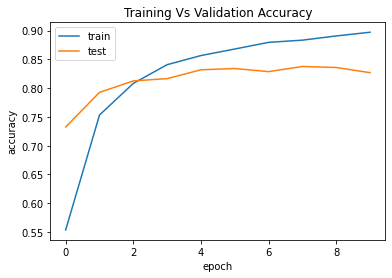

In [ ]:
# plot accuracy (train vs val)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

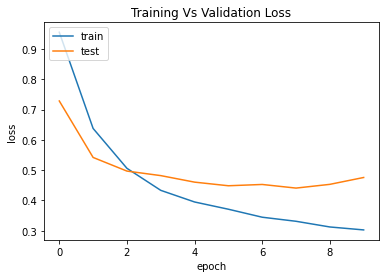

In [ ]:
# plot loss (train vs val)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Best model validation

Single layer lstm(20 epoch)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#Let's load the best model obtained during training
best_model1 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_lstm.hdf5")

In [ ]:
test_loss, test_acc = best_model1.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 8s 28ms/step - loss: 0.4099 - accuracy: 0.8464
Model accuracy:  0.8464449048042297


In [ ]:
predictions = np.around(best_model1.predict(X_test))

157/157 [==============================] - 3s 18ms/step


In [ ]:
classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1966
           1       0.83      0.73      0.78      1505
           2       0.86      0.87      0.87      1550

   micro avg       0.86      0.83      0.84      5021
   macro avg       0.85      0.83      0.84      5021
weighted avg       0.85      0.83      0.84      5021
 samples avg       0.83      0.83      0.83      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

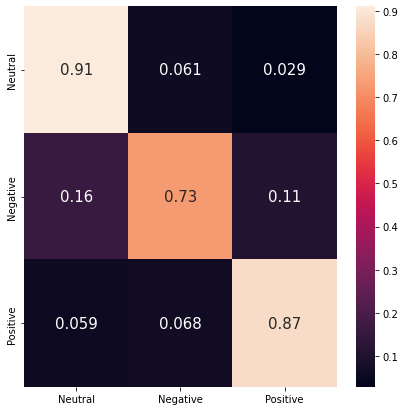

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['I love Bitcoin!'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 42ms/step


'Neutral'

Single layer bilstm(20 epoch)

In [ ]:
#Let's load the best model obtained during training
best_model2 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_bilstm.hdf5")

In [ ]:
test_loss, test_acc = best_model2.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 6s 29ms/step - loss: 0.4020 - accuracy: 0.8508
Model accuracy:  0.8508265018463135


In [ ]:
predictions = np.around(best_model2.predict(X_test))

157/157 [==============================] - 5s 27ms/step


In [ ]:
predictions

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1966
           1       0.83      0.73      0.78      1505
           2       0.87      0.89      0.88      1550

   micro avg       0.86      0.84      0.85      5021
   macro avg       0.86      0.84      0.84      5021
weighted avg       0.86      0.84      0.85      5021
 samples avg       0.84      0.84      0.84      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

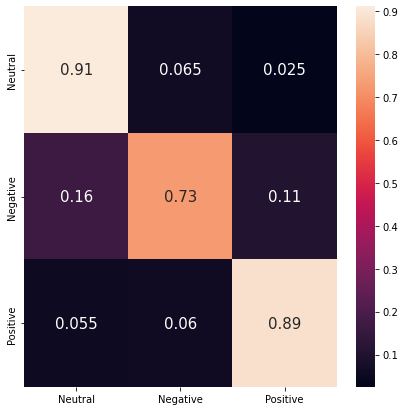

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Single layer rnn(20 epoch)

In [ ]:
#Let's load the best model obtained during training
best_model0 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_rnn.hdf5")

In [ ]:
test_loss, test_acc = best_model0.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 3s 15ms/step - loss: 0.4618 - accuracy: 0.8375
Model accuracy:  0.8374825716018677


In [ ]:
predictions = np.around(best_model0.predict(X_test))

157/157 [==============================] - 3s 19ms/step


In [ ]:
predictions

array([[0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1966
           1       0.84      0.71      0.77      1505
           2       0.86      0.84      0.85      1550

   micro avg       0.84      0.83      0.84      5021
   macro avg       0.85      0.82      0.83      5021
weighted avg       0.85      0.83      0.84      5021
 samples avg       0.83      0.83      0.83      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

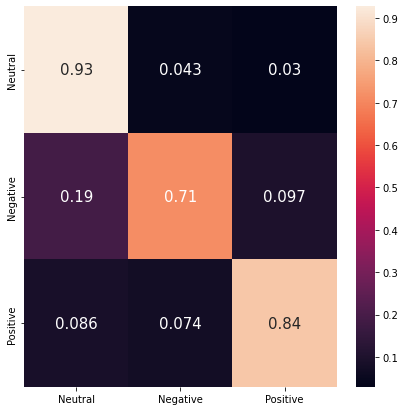

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Double lstm(20 epoch)

In [ ]:
#Let's load the best model obtained during training
best_model3 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_double_lstm.hdf5")

In [ ]:
test_loss, test_acc = best_model3.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 8s 46ms/step - loss: 0.4159 - accuracy: 0.8512
Model accuracy:  0.8512248396873474


In [ ]:
predictions = np.around(best_model3.predict(X_test))

157/157 [==============================] - 10s 48ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1966
           1       0.87      0.70      0.78      1505
           2       0.85      0.90      0.87      1550

   micro avg       0.86      0.84      0.85      5021
   macro avg       0.86      0.83      0.84      5021
weighted avg       0.86      0.84      0.85      5021
 samples avg       0.84      0.84      0.84      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

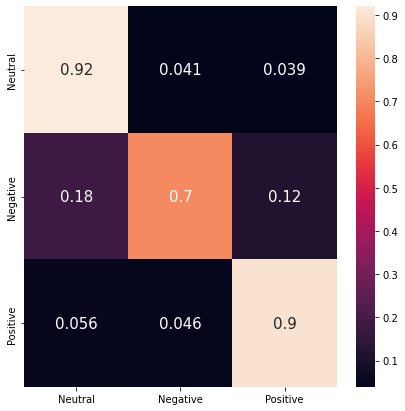

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

cnn-lstm 20 epoch

In [ ]:
#Let's load the best model obtained during training
best_model4 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_cnn_lstm.hdf5")

In [ ]:
test_loss, test_acc = best_model4.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 2s 8ms/step - loss: 0.4765 - accuracy: 0.8277
Model accuracy:  0.8277235627174377


In [ ]:
predictions = np.around(best_model4.predict(X_test))

157/157 [==============================] - 6s 15ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1966
           1       0.81      0.72      0.76      1505
           2       0.85      0.84      0.84      1550

   micro avg       0.83      0.82      0.83      5021
   macro avg       0.83      0.81      0.82      5021
weighted avg       0.83      0.82      0.83      5021
 samples avg       0.82      0.82      0.82      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

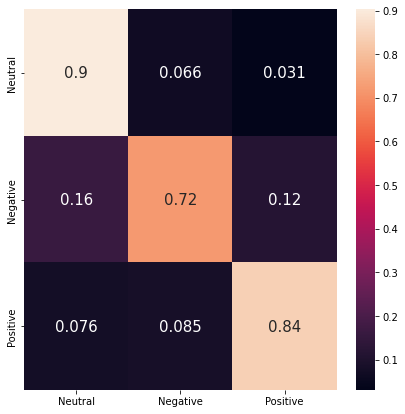

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

cnn-lstm 10 epoch

In [ ]:
#Let's load the best model obtained during training
best_model4_2 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_cnn_lstm(10epoch).hdf5")

In [ ]:
test_loss, test_acc = best_model4_2.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 2s 10ms/step - loss: 0.4621 - accuracy: 0.8337
Model accuracy:  0.8336984515190125


In [ ]:
predictions = np.around(best_model4_2.predict(X_test))

157/157 [==============================] - 2s 8ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1966
           1       0.83      0.71      0.77      1505
           2       0.86      0.83      0.85      1550

   micro avg       0.85      0.82      0.83      5021
   macro avg       0.84      0.82      0.83      5021
weighted avg       0.84      0.82      0.83      5021
 samples avg       0.82      0.82      0.82      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

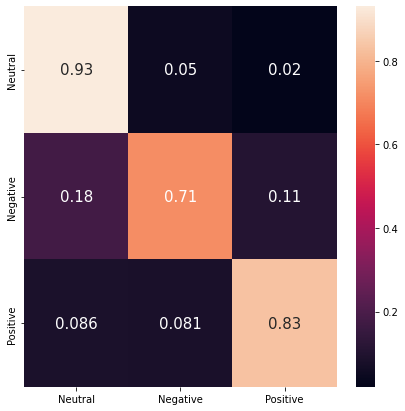

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

cnn-bilstm 10 epoch

In [ ]:
#Let's load the best model obtained during training
best_model5 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_single_cnn_bilstm2.hdf5")

In [ ]:
test_loss, test_acc = best_model5.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 3s 11ms/step - loss: 0.4635 - accuracy: 0.8333
Model accuracy:  0.8333001136779785


In [ ]:
predictions = np.around(best_model5.predict(X_test))

157/157 [==============================] - 4s 17ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1966
           1       0.83      0.72      0.77      1505
           2       0.84      0.85      0.85      1550

   micro avg       0.84      0.83      0.83      5021
   macro avg       0.84      0.82      0.83      5021
weighted avg       0.84      0.83      0.83      5021
 samples avg       0.83      0.83      0.83      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

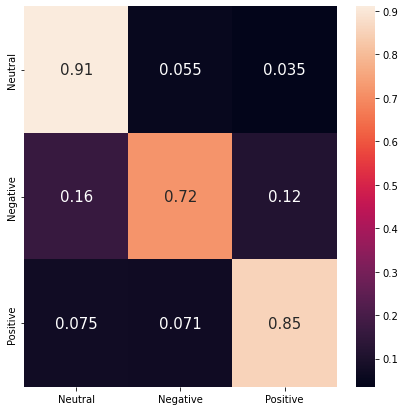

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

kfold single LSTM 20 epoch

In [ ]:
#Let's load the best model obtained during training
best_model6 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_kfold_single_lstm.hdf5")

In [ ]:
test_loss, test_acc = best_model6.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 3s 19ms/step - loss: 0.5670 - accuracy: 0.7726
Model accuracy:  0.7725552916526794


In [ ]:
predictions = np.around(best_model6.predict(X_test))

157/157 [==============================] - 3s 18ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1966
           1       0.85      0.56      0.68      1505
           2       0.83      0.73      0.78      1550

   micro avg       0.80      0.73      0.77      5021
   macro avg       0.81      0.72      0.76      5021
weighted avg       0.81      0.73      0.76      5021
 samples avg       0.73      0.73      0.73      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

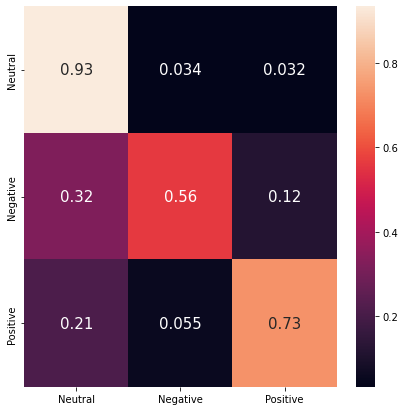

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

kfold single LSTM 30 epoch

In [ ]:
#Let's load the best model obtained during training
best_model7 = keras.models.load_model("/content/drive/MyDrive/Models/3rd_try_kfold_single_lstm2(30_epoch).hdf5")

In [ ]:
test_loss, test_acc = best_model7.evaluate(X_test, y_test, verbose=1)
print('Model accuracy: ',test_acc)

157/157 [==============================] - 5s 26ms/step - loss: 0.5017 - accuracy: 0.8042
Model accuracy:  0.8042222857475281


In [ ]:
predictions = np.around(best_model7.predict(X_test))

157/157 [==============================] - 6s 35ms/step


In [ ]:
predictions

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

classification_report = classification_report(y_test, predictions)

# Display the classification report
print(classification_report)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1966
           1       0.82      0.65      0.72      1505
           2       0.85      0.78      0.82      1550

   micro avg       0.82      0.78      0.80      5021
   macro avg       0.83      0.77      0.79      5021
weighted avg       0.83      0.78      0.80      5021
 samples avg       0.78      0.78      0.78      5021



In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

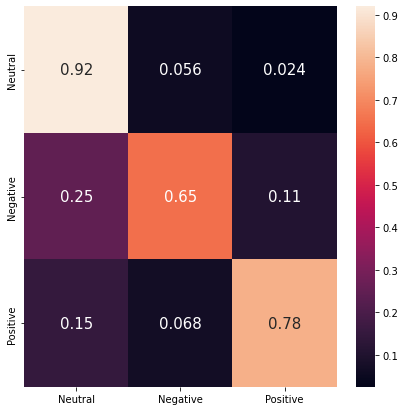

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
#predictions = best_model.predict(X_test)

176/176 [==============================] - 6s 27ms/step


##Naive Bayes Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
y_test_le = y_test2.copy()

In [ ]:
y_train_le = y_train2.copy()

In [ ]:
'''from sklearn import preprocessing
ohe = preprocessing.OneHotEncoder()
y_train2 = ohe.fit_transform(np.array(y_train2).reshape(-1, 1)).toarray()'''
#y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()'''

'from sklearn import preprocessing\nohe = preprocessing.OneHotEncoder()\ny_train2 = ohe.fit_transform(np.array(y_train2).reshape(-1, 1)).toarray()'

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train2)

In [ ]:
X_test_cv = clf.transform(X_test2)

In [ ]:
tf_transformer = TfidfTransformer().fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)

In [ ]:
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

#accuracy = accuracy_score(data2_['sentiment'], data2_['TextBlob_Analysis'])

#print("Accuracy: {}\n".format(accuracy))

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.75      0.84      0.79      1966
     Neutral       0.81      0.60      0.69      1505
    Positive       0.72      0.79      0.75      1550

    accuracy                           0.75      5021
   macro avg       0.76      0.74      0.74      5021
weighted avg       0.76      0.75      0.75      5021



## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), nb_pred)

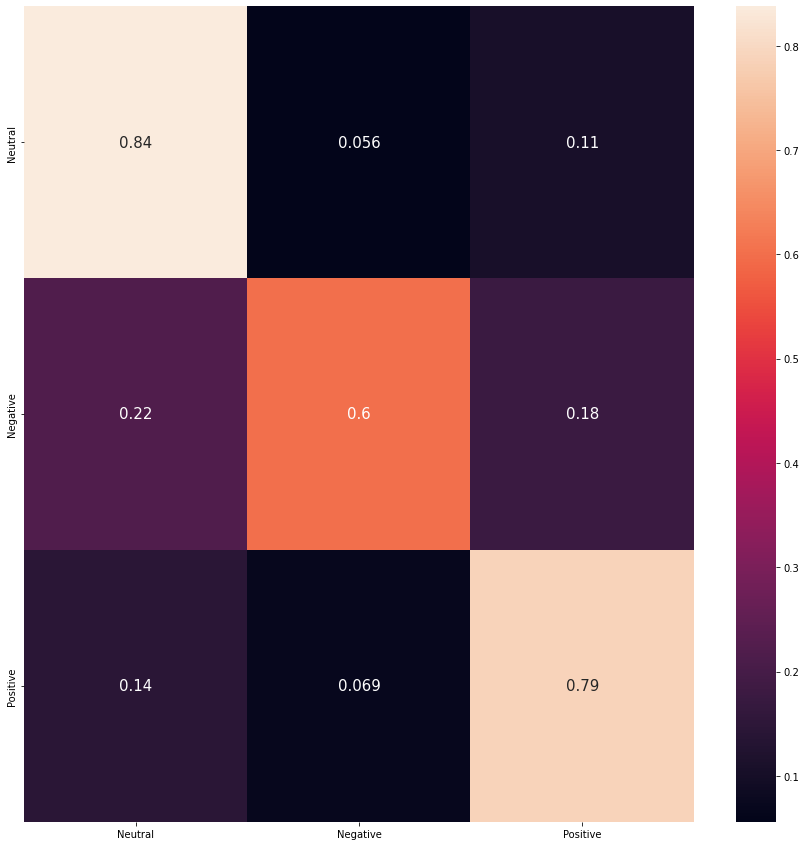

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['bitcoin value decreased by 1% today, hurrah for altcoin'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 27ms/step


'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 31ms/step


'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 32ms/step


'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 29ms/step


'Positive'

##Comparison with vader

In [ ]:
#comp = test set

In [ ]:
# Install and import nltk
!pip install nltk
import nltk

# Download the lexicon
nltk.download("vader_lexicon")

# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# A last example with negative sentiment
negative_sent = "bitcoin value decreased by 1% today, hurrah for altcoin"
print(sent_analyzer.polarity_scores(negative_sent))

{'neg': 0.0, 'neu': 0.538, 'pos': 0.462, 'compound': 0.7184}


In [ ]:
def format_output(output_dict):
  
  polarity = "Neutral"

  if(output_dict['compound']>= 0.05):
    polarity = "Positive"

  elif(output_dict['compound']<= -0.05):
    polarity = "Negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

# Run the predictions
comp["vader_prediction"] = comp["text"].astype(str).apply(predict_sentiment)

# Show 5 random rows of the data
comp.sample(5)

,text,sentiment,vader_prediction
1423,dutch authorities have seized bitcoin mixing s...,Negative,Neutral
4103,rt in it and must include the following hashta...,Neutral,Neutral
834,this book which we refer to simply as wireshar...,Neutral,Neutral
4704,rt freezone will change your life forever cryp...,Neutral,Neutral
952,btc down in the last hour bitcoin bitsmart,Negative,Neutral


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(comp['sentiment'], comp['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(comp['sentiment'], comp['vader_prediction']))

Accuracy: 0.5124477195777734

              precision    recall  f1-score   support

    Negative       0.43      0.22      0.29      1505
     Neutral       0.54      0.62      0.58      1966
    Positive       0.52      0.66      0.58      1550

    accuracy                           0.51      5021
   macro avg       0.49      0.50      0.48      5021
weighted avg       0.50      0.51      0.49      5021



##Comparison with TextBlob

In [ ]:
from textblob import TextBlob

In [ ]:
data2=comp.copy()

In [ ]:
data2 = data2.drop(['vader_prediction'], axis=1)

In [ ]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

#Create two new columns ‘Subjectivity’ & ‘Polarity’
data2["TextBlob_Subjectivity"] = data2["text"].apply(getSubjectivity)
data2["TextBlob_Polarity"] = data2["text"].apply(getPolarity)




In [ ]:
def getAnalysis(score):
  if score < 0:
    return "Negative"
  elif score == 0:
    return "Neutral"
  else:
    return "Positive"

data2["TextBlob_Analysis"] = data2["TextBlob_Polarity"].apply(getAnalysis)

In [ ]:
data2_ = data2.copy()

In [ ]:
data2_.drop(['TextBlob_Subjectivity','TextBlob_Polarity'], axis=1)

,text,sentiment,TextBlob_Analysis
0,puerto rico creates working group to review bl...,Neutral,Neutral
1,in the book we will be talking about deploying...,Positive,Positive
2,an online service for working with mirabox con...,Neutral,Neutral
3,our team at the satoshi vision conference in t...,Neutral,Neutral
4,the us postal service is looking at backing up...,Neutral,Neutral
...,...,...,...
5016,europefx latest in celebrity bitcoin trading s...,Negative,Positive
5017,how to get free bitcoin money,Positive,Positive
5018,ramencoin airdrop ramencoin ramen airdrop boun...,Neutral,Neutral
5019,gbpcad bull flag gbpcad tradingview forex fore...,Neutral,Neutral


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(data2_['sentiment'], data2_['TextBlob_Analysis'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(data2_['sentiment'], data2_['TextBlob_Analysis']))

Accuracy: 0.8364867556263692

              precision    recall  f1-score   support

    Negative       0.97      0.50      0.66      1505
     Neutral       0.83      0.98      0.90      1966
    Positive       0.79      0.99      0.88      1550

    accuracy                           0.84      5021
   macro avg       0.86      0.82      0.81      5021
weighted avg       0.86      0.84      0.82      5021



In [ ]:
#best_mode1 best_model2 best_model3

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
text_ui =[]

print('Give your input')

text_ui.append(input())

Give your input
i really love bitcoin


In [ ]:
sequence = tokenizer.texts_to_sequences(text_ui)
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 405ms/step


'Positive'

In [ ]:
#sequence = tokenizer.texts_to_sequences(text_ui)
#test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 768ms/step


'Positive'

In [ ]:
#sequence = tokenizer.texts_to_sequences(text_ui)
#test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model3.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Positive'